In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from pprint import pprint

# df = pl.read_parquet('data/ca_combined_data.parquet')
# print(f"Dataset shape: {df.shape}")
# print(f"Memory usage: {df.estimated_size(unit='gb'):,.2f} GB")
# del df

df = pl.scan_parquet('data/ca_combined_data.parquet')

## Data Preparation

### Optimize Storage Types

In [2]:
df = (
    df
    .with_columns(pl.col('burned_area').cast(pl.UInt8))
    .with_columns(pl.col('month').cast(pl.UInt8))
    .with_columns(pl.col('year').cast(pl.UInt16))
    .with_columns(pl.col("landcover").cast(pl.UInt8))
)

### Drop Null Values

In [3]:
with pl.Config(tbl_rows=-1):
    print(
        df.null_count()
        .collect(engine="streaming")
        .transpose(include_header=True, header_name="column")
        .rename({"column_0": "null_count"})
    )

shape: (14, 2)
┌─────────────┬────────────┐
│ column      ┆ null_count │
│ ---         ┆ ---        │
│ str         ┆ u32        │
╞═════════════╪════════════╡
│ lat         ┆ 0          │
│ lon         ┆ 0          │
│ ppt         ┆ 238503900  │
│ year        ┆ 0          │
│ month       ┆ 0          │
│ tdmean      ┆ 238503900  │
│ tmax        ┆ 238503900  │
│ vpdmax      ┆ 238503900  │
│ burned_area ┆ 0          │
│ ndvi        ┆ 244297858  │
│ landcover   ┆ 243595284  │
│ elevation   ┆ 237697500  │
│ slope       ┆ 237697500  │
│ aspect      ┆ 237697500  │
└─────────────┴────────────┘


In [4]:
df = df.filter(
    ~(
        pl.any_horizontal(pl.all().is_null())
    )
)

In [5]:
with pl.Config(tbl_rows=-1):
    print(
        df.null_count()
        .collect(engine="streaming")
        .transpose(include_header=True, header_name="column")
        .rename({"column_0": "null_count"})
    )

shape: (14, 2)
┌─────────────┬────────────┐
│ column      ┆ null_count │
│ ---         ┆ ---        │
│ str         ┆ u32        │
╞═════════════╪════════════╡
│ lat         ┆ 0          │
│ lon         ┆ 0          │
│ ppt         ┆ 0          │
│ year        ┆ 0          │
│ month       ┆ 0          │
│ tdmean      ┆ 0          │
│ tmax        ┆ 0          │
│ vpdmax      ┆ 0          │
│ burned_area ┆ 0          │
│ ndvi        ┆ 0          │
│ landcover   ┆ 0          │
│ elevation   ┆ 0          │
│ slope       ┆ 0          │
│ aspect      ┆ 0          │
└─────────────┴────────────┘


In [ ]:
# Visualize mean values of variables spatially
cols_to_agg = ['ppt', 'tdmean', 'tmax', 'vpdmax', 'ndvi', 'landcover', 'elevation', 'slope', 'aspect']

spatial_means = df.group_by(['lat', 'lon']).agg(
    [pl.col(c).mean().alias(c) for c in cols_to_agg]
)

def plot_mean_map(target_col):
    # Collect data for plotting
    print(f"Collecting data for {target_col}")
    plot_data = spatial_means.select(['lat', 'lon', target_col]).collect(engine="streaming")
    print("Collected data")
    
    plt.figure(figsize=(12, 10))
    
    # Scatter plot
    print("Plotting")
    sc = plt.scatter(
        plot_data['lon'], 
        plot_data['lat'], 
        c=plot_data[target_col], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(sc, label=f"{target_col} mean")
    
    plt.title(f"Spatial Distribution of {target_col}", fontsize=14, fontweight='bold')
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Set aspect ratio to 'equal' to preserve map shape
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

Collected data
Plotting


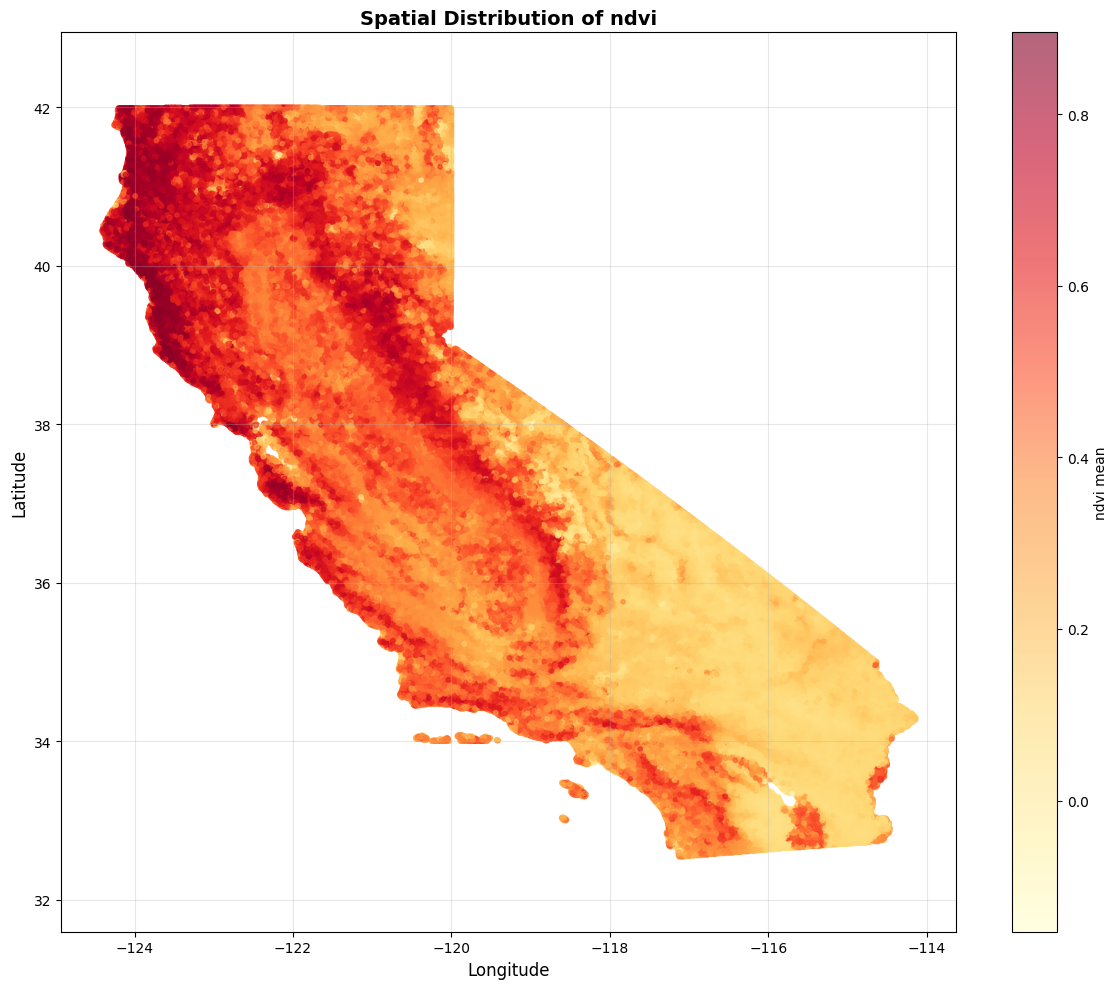

In [6]:
plot_mean_map('ndvi')

Collected data
Plotting


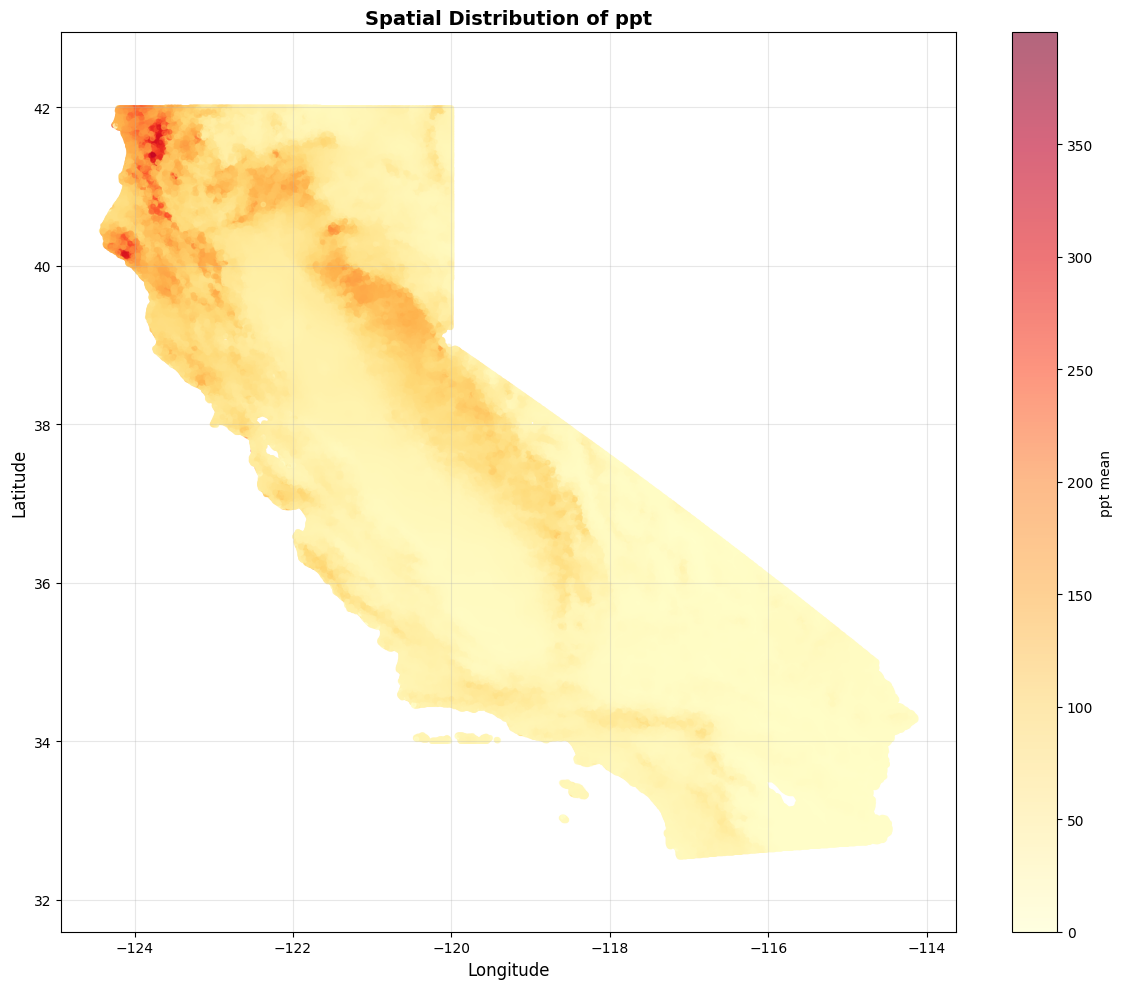

In [7]:
plot_mean_map('ppt')

Collected data
Plotting


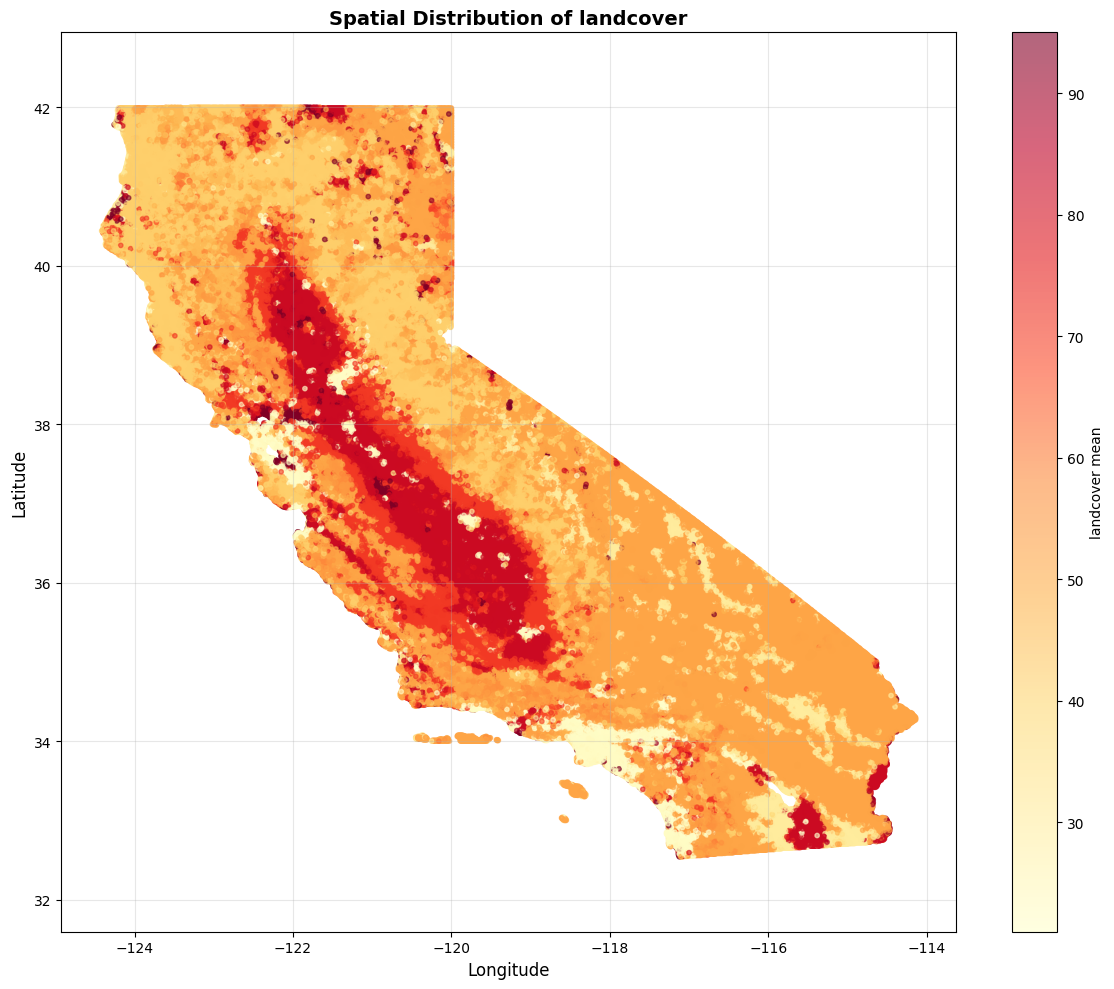

In [8]:
plot_mean_map('landcover')

Collected data
Plotting


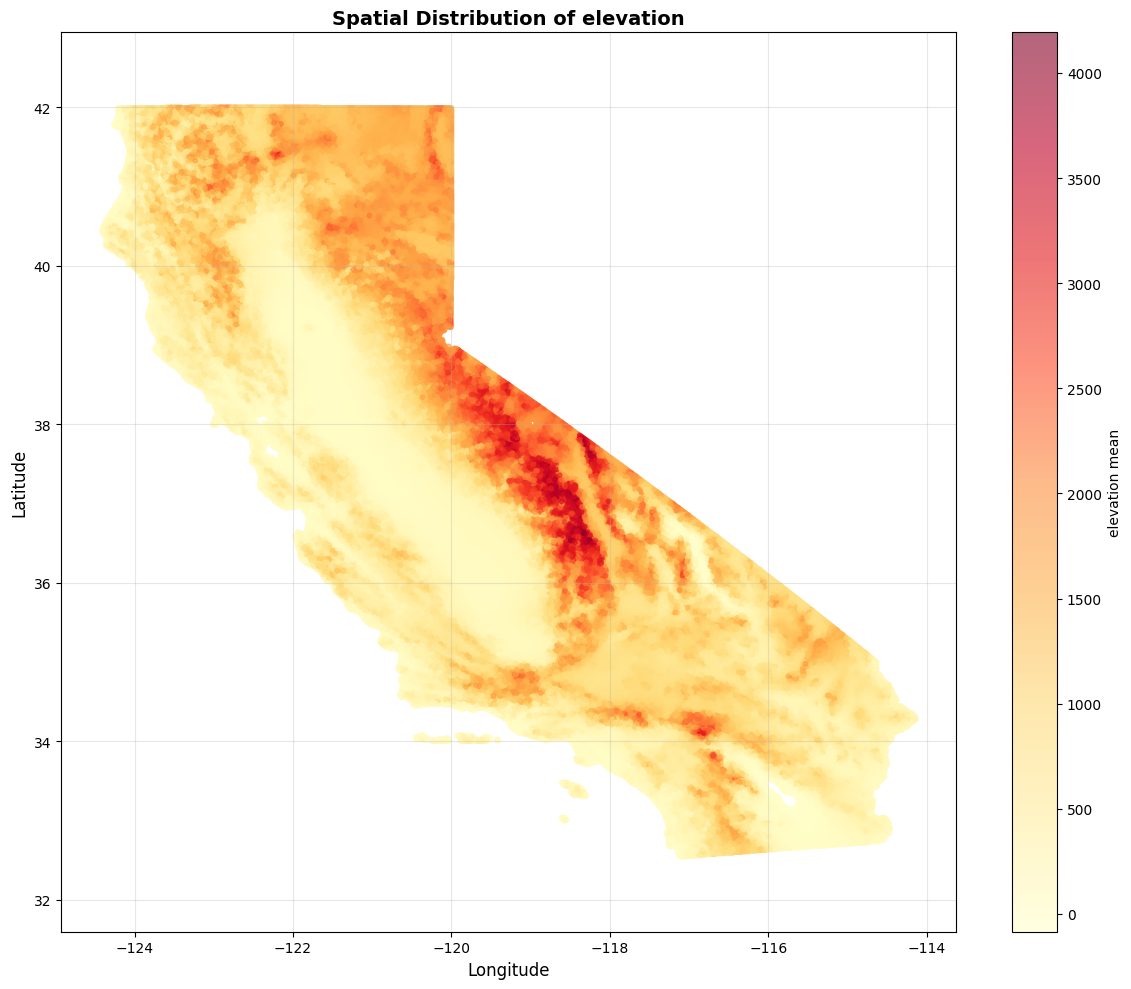

In [9]:
plot_mean_map('elevation')

### Lag Inputs

In [6]:
df = df.sort(["lat", "lon", "year", "month"]).with_columns(
    pl.col("burned_area").shift(1).over(["lat", "lon"]).alias("burned_area")
).drop_nulls(subset=["burned_area"])

In [7]:
df.select(pl.len()).collect(engine="streaming").item()

177727298

### Coordinate Anomalies

In [ ]:
print(
    df.group_by(['lat', 'lon'])
    .len()
    .collect(engine="streaming")
    .get_column("len")  # Select the count column
    .unique()
    .sort()
)

shape: (292,)
Series: 'len' [u32]
[
	1
	2
	3
	4
	5
	…
	294
	295
	296
	297
	298
]


Total unique locations: 598099
Min count: 1
Max count: 298
Median count: 298.0


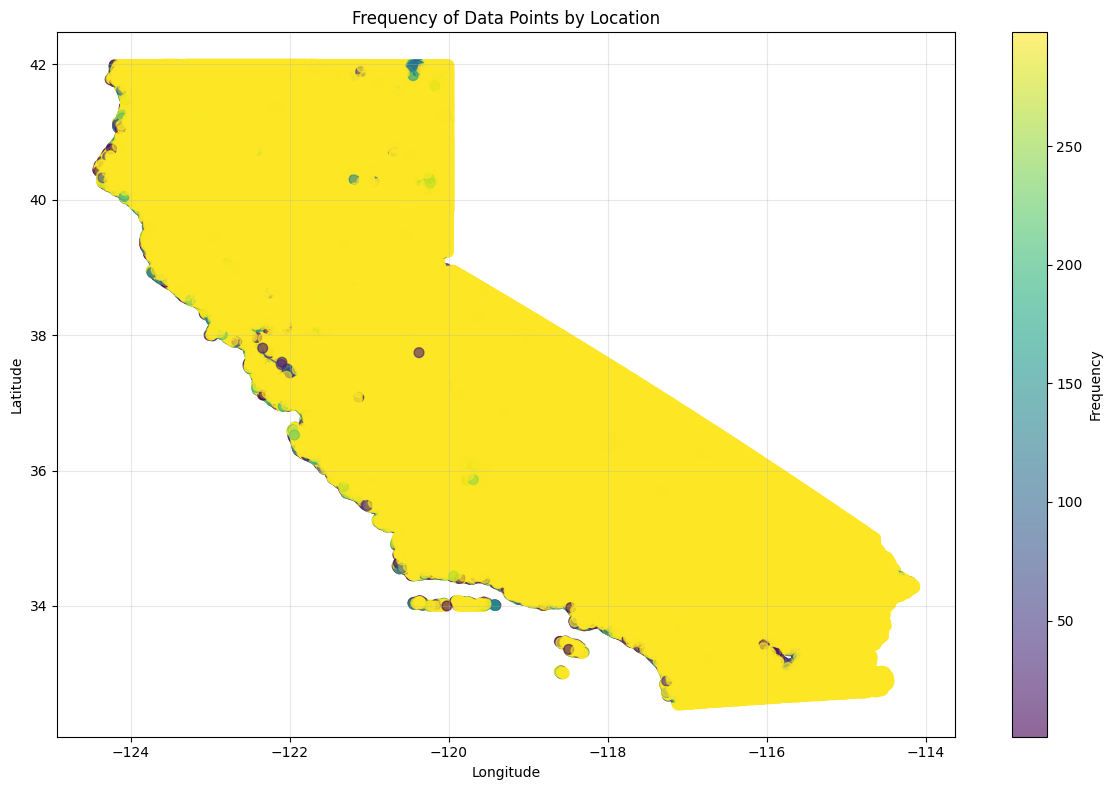

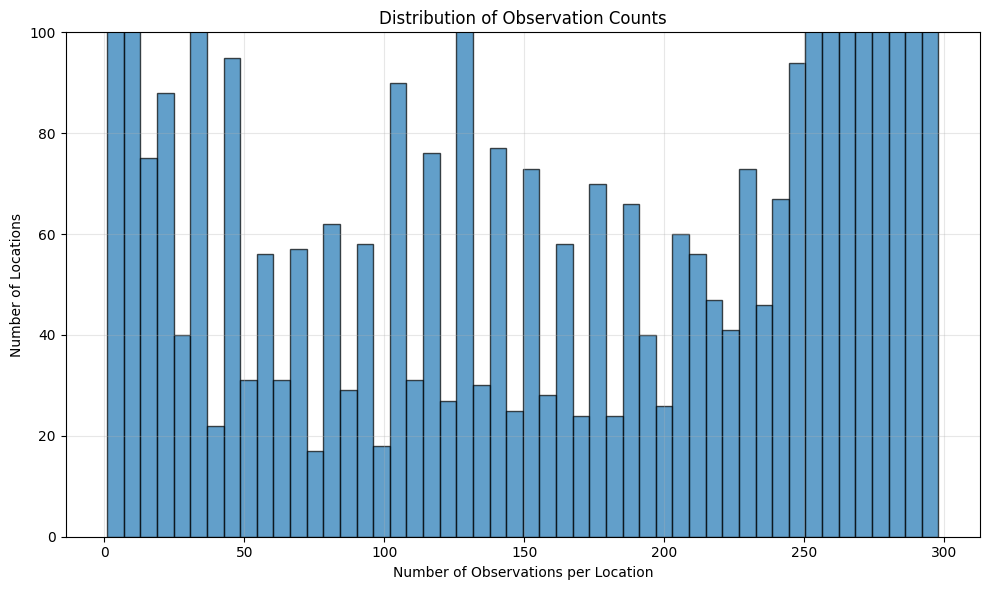

In [ ]:
def plot_coord_count_pl(df):
    location_counts = df.group_by(['lat', 'lon']).len().collect(engine="streaming")
    
    print(f"Total unique locations: {location_counts.height}")
    print(f"Min count: {location_counts['len'].min()}")
    print(f"Max count: {location_counts['len'].max()}")
    print(f"Median count: {location_counts['len'].median():.1f}")

    # Visualization 1: Spatial heatmap
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(location_counts['lon'], location_counts['lat'], 
                        c=location_counts['len'],
                        cmap='viridis', 
                        s=50, 
                        alpha=0.6)
    plt.colorbar(scatter, label='Frequency')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Frequency of Data Points by Location')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualization 2: Histogram of frequencies
    plt.figure(figsize=(10, 6))
    plt.hist(location_counts['len'], bins=50, edgecolor='black', alpha=0.7)
    plt.ylim(0, 100)
    plt.xlabel('Number of Observations per Location')
    plt.ylabel('Number of Locations')
    plt.title('Distribution of Observation Counts')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_coord_count_pl(df)

#### Keep coordinates that have max count

In [8]:
df = df.with_columns(
    pl.len().over(['lat', 'lon']).alias("group_len")
).filter(
    pl.col("group_len") == pl.col("group_len").max()
).drop("group_len")

Total unique locations: 588369
Min count: 298
Max count: 298
Median count: 298.0


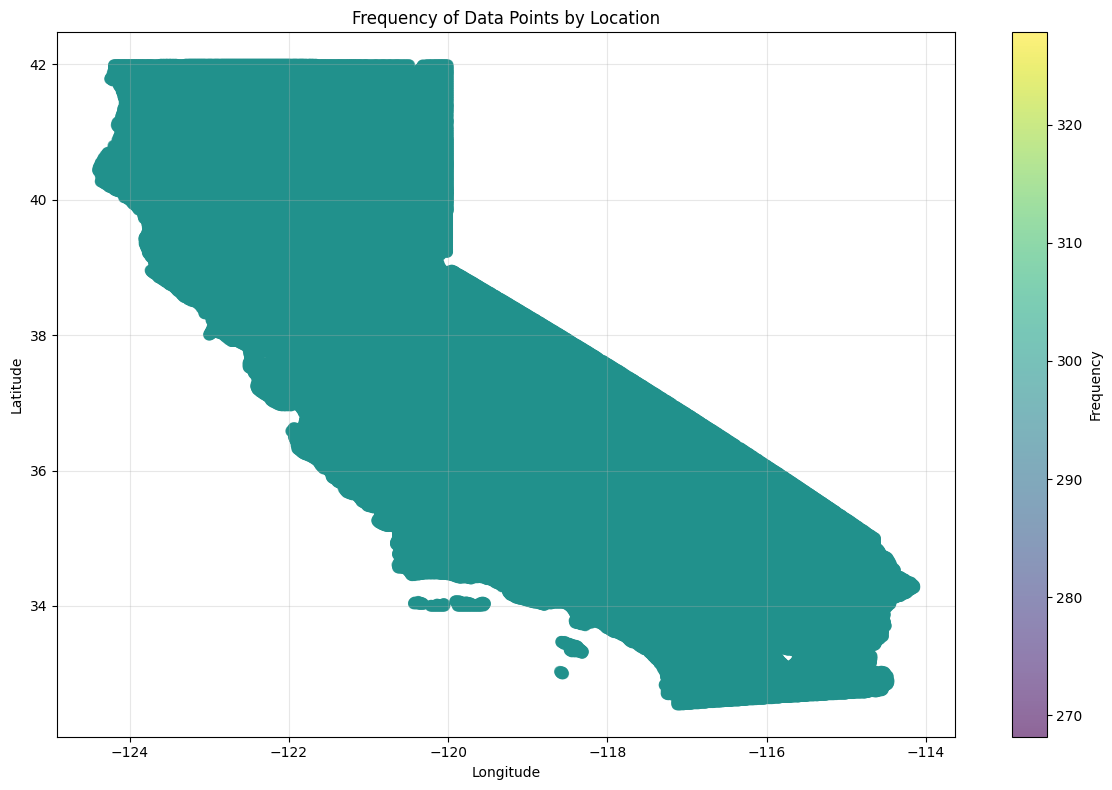

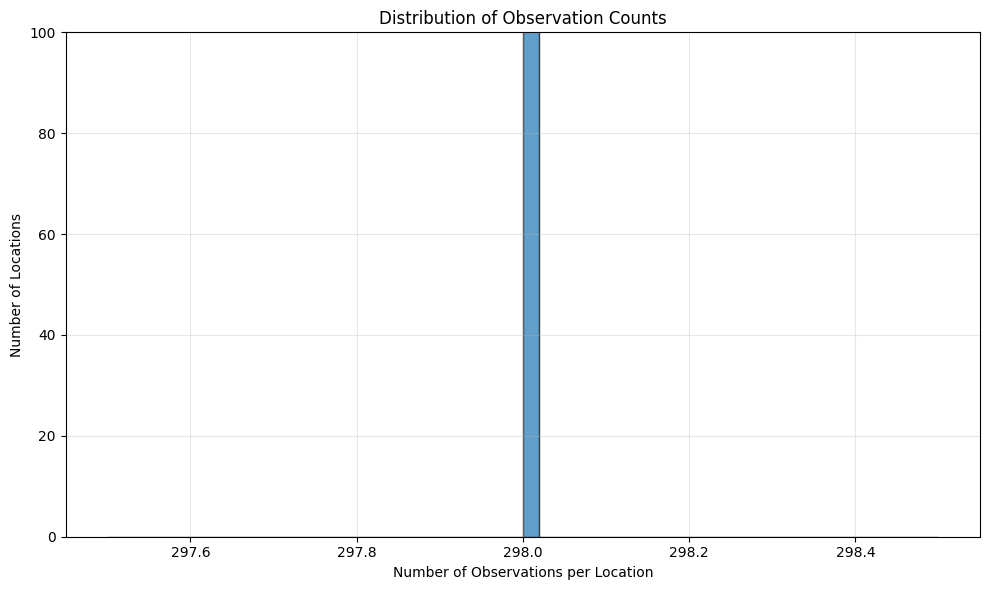

In [ ]:
plot_coord_count_pl(df)

In [9]:
temp_df = df.collect(engine="streaming")
print(f"Memory usage: {temp_df.estimated_size(unit='gb'):,.2f} GB")
del temp_df

Memory usage: 13.88 GB


## Feature Engineering

### Log Transformations

In [10]:
log_variables = ['ppt', 'vpdmax', 'elevation', 'slope']

df = df.with_columns(
    [pl.col(var).log1p().alias(f"{var}_log") for var in log_variables]
).drop(log_variables)

### One-Hot Encode Landcover

In [11]:
landcover_class_names = {
    11: 'Open_Water',
    12: 'Perennial_Ice_Snow',
    21: 'Developed_Open_Space',
    22: 'Developed_Low_Intensity',
    23: 'Developed_Medium_Intensity',
    24: 'Developed_High_Intensity',
    31: 'Barren_Land',
    41: 'Deciduous_Forest',
    42: 'Evergreen_Forest',
    43: 'Mixed_Forest',
    51: 'Dwarf_Scrub',
    52: 'Shrub_Scrub',
    71: 'Grassland_Herbaceous',
    72: 'Sedge_Herbaceous',
    73: 'Lichens',
    74: 'Moss',
    81: 'Pasture_Hay',
    82: 'Cultivated_Crops',
    90: 'Woody_Wetlands',
    95: 'Emergent_Herbaceous_Wetlands'
}

all_landcover_classes = [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 
                         51, 52, 71, 72, 73, 74, 81, 82, 90, 95]

one_hot_exprs = [
    (pl.col('landcover') == landcover_class)
    .cast(pl.UInt8)
    .alias(f'landcover_{landcover_class_names[landcover_class].lower()}')
    for landcover_class in all_landcover_classes
]

df_encoded = (
    df
    .with_columns(one_hot_exprs)
    .drop('landcover')
)

In [12]:
df_encoded.head().collect(engine="streaming")

lat,lon,year,month,tdmean,tmax,burned_area,ndvi,aspect,ppt_log,vpdmax_log,elevation_log,slope_log,landcover_open_water,landcover_perennial_ice_snow,landcover_developed_open_space,landcover_developed_low_intensity,landcover_developed_medium_intensity,landcover_developed_high_intensity,landcover_barren_land,landcover_deciduous_forest,landcover_evergreen_forest,landcover_mixed_forest,landcover_dwarf_scrub,landcover_shrub_scrub,landcover_grassland_herbaceous,landcover_sedge_herbaceous,landcover_lichens,landcover_moss,landcover_pasture_hay,landcover_cultivated_crops,landcover_woody_wetlands,landcover_emergent_herbaceous_wetlands
f64,f64,u16,u8,f64,f64,u8,f64,f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
32.54167,-117.125,2000,3,9.695,17.980001,0,0.3893,-0.048678,3.44045,2.239752,0.98405,0.009539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2000,4,12.086,19.570002,0,0.4625,-0.048678,2.644102,2.317277,0.98405,0.009539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2000,5,13.502,21.190001,0,0.4964,-0.048678,0.0,2.363492,0.98405,0.009539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2000,6,15.201,21.030001,0,0.3504,-0.048678,0.0,2.075935,0.98405,0.009539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32.54167,-117.125,2000,7,15.693,21.950001,0,0.3333,-0.048678,0.0,2.213207,0.98405,0.009539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### PCA

In [ ]:
# TBD

## Data Splitting

### Train Test Validation Split

In [13]:
validation_set = df_encoded.filter(
    (pl.col('year') >= 2005) & (pl.col('year') <= 2009)
)

remaining_data = df_encoded.filter(
    (pl.col('year') < 2005) | (pl.col('year') > 2009)
)

test_size = 0.3
seed = 42

# Generate shuffled indices
n_rows = remaining_data.select(pl.len()).collect(engine="streaming").item()
indices = np.arange(n_rows)
np.random.seed(seed)
np.random.shuffle(indices)

# Split indices
split_idx = int(n_rows * (1-test_size))
train_idx = set(indices[:split_idx].tolist())
test_idx = set(indices[split_idx:].tolist())

# Create train/test sets
remaining_data = remaining_data.with_row_index('_idx')

train_data = remaining_data.filter(pl.col('_idx').is_in(train_idx)).drop('_idx')
test_data = remaining_data.filter(pl.col('_idx').is_in(test_idx)).drop('_idx')

X_train = train_data.drop('burned_area')
y_train = train_data.select('burned_area')
X_test = test_data.drop('burned_area')
y_test = test_data.select('burned_area')
X_validation = validation_set.drop('burned_area')
y_validation = validation_set.select('burned_area')

### Normalize

In [14]:
class PolarsScaler:
    def __init__(self, columns_to_scale: list[str] | None = None):
        """
        Polars-native StandardScaler that works with LazyFrames.
        
        Args:
            columns_to_scale: List of column names to scale. 
                              If None, scales all numeric columns.
        """
        self.columns_to_scale = columns_to_scale
        self.means: dict[str, float] = {}
        self.stds: dict[str, float] = {}
    
    def fit(self, X: pl.LazyFrame | pl.DataFrame) -> "PolarsScaler":
        """Compute mean and std for each column. Only collects 1 row of stats."""
        if isinstance(X, pl.DataFrame):
            X = X.lazy()
        
        if self.columns_to_scale is None:
            schema = X.collect_schema()
            self.columns_to_scale = [
                name for name, dtype in schema.items() 
                if dtype.is_numeric()
            ]
        
        stats = X.select([
            *[pl.col(c).mean().alias(f"{c}_mean") for c in self.columns_to_scale],
            *[pl.col(c).std().alias(f"{c}_std") for c in self.columns_to_scale],
        ]).collect(engine="streaming")
        
        for col in self.columns_to_scale:
            self.means[col] = stats[f"{col}_mean"][0]
            self.stds[col] = stats[f"{col}_std"][0] or 1.0
        
        return self
    
    def transform(self, X: pl.LazyFrame | pl.DataFrame) -> pl.LazyFrame | pl.DataFrame:
        """Scale columns: (X - mean) / std. Stays lazy if input is lazy."""
        is_dataframe = isinstance(X, pl.DataFrame)
        if is_dataframe:
            X = X.lazy()
        
        scale_exprs = [
            ((pl.col(col) - self.means[col]) / self.stds[col]).alias(col)
            for col in self.columns_to_scale
        ]
        
        result = X.with_columns(scale_exprs)
        return result.collect(engine="streaming") if is_dataframe else result
    
    def fit_transform(self, X: pl.LazyFrame | pl.DataFrame) -> pl.LazyFrame | pl.DataFrame:
        """Fit and transform in one step."""
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X: pl.LazyFrame | pl.DataFrame) -> pl.LazyFrame | pl.DataFrame:
        """Reverse scaling: X * std + mean. Stays lazy if input is lazy."""
        is_dataframe = isinstance(X, pl.DataFrame)
        if is_dataframe:
            X = X.lazy()
        
        inverse_exprs = [
            (pl.col(col) * self.stds[col] + self.means[col]).alias(col)
            for col in self.columns_to_scale
        ]
        
        result = X.with_columns(inverse_exprs)
        return result.collect(engine="streaming") if is_dataframe else result

In [15]:
columns_to_scale = [col for col in X_train.collect_schema().names() if not col.startswith('landcover_')]
scaler = PolarsScaler(columns_to_scale=columns_to_scale)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

### Save to Shared Data Directory

In [16]:
# Save to parquet in shared data directory
data_dir = Path.home() / "teams/b13-domain-2/ca_data/"

X_train_scaled.sink_parquet(data_dir / "X_train.parquet", engine="streaming")
y_train.sink_parquet(data_dir / "y_train.parquet", engine="streaming")
X_test_scaled.sink_parquet(data_dir / "X_test.parquet", engine="streaming")
y_test.sink_parquet(data_dir / "y_test.parquet", engine="streaming")
X_validation_scaled.sink_parquet(data_dir / "X_validation.parquet", engine="streaming")
y_validation.sink_parquet(data_dir / "y_validation.parquet", engine="streaming")